In [171]:
import cbmpy
from cbmpy.CBModel import Model, Reaction
import pandas as pd
from dcFBA.Models import CommunityModel
%load_ext autoreload
%autoreload 2
from ecoli_models import (
    get_leucine_knock_out_model,
    get_lysine_knock_out_model,
)
%load_ext autoreload
%autoreload 2
from dcFBA.DynamicModels import EndPointFBA
from dcFBA.Helpers.PlotsEndPointFBA import plot_biomasses, plot_metabolites

import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [165]:
leucine_knock_out = get_leucine_knock_out_model()
lysine_knock_out = get_lysine_knock_out_model()

leucine_knock_out.getReaction("R_GLCtex_copy1").setUpperBound(8)
leucine_knock_out.getReaction("R_GLCtex_copy2").setUpperBound(0)
lysine_knock_out.getReaction("R_GLCtex_copy1").setUpperBound(8)
lysine_knock_out.getReaction("R_GLCtex_copy2").setUpperBound(0)

#Restrict the uptake of leucine in the knockout:
leucine_knock_out.getReaction("R_LEUtex").setUpperBound(3)
#Restrict the lysine uptake in lysine knock out
lysine_knock_out.getReaction("R_LYStex").setUpperBound(3)


getState1
Model clone time: 2.492764949798584
getState1
Model clone time: 2.076180934906006


In [166]:
community_model = CommunityModel(
    [leucine_knock_out, lysine_knock_out],
    ["R_BIOMASS_Ec_iAF1260_core_59p81M", "R_BIOMASS_Ec_iAF1260_core_59p81M"],
    ["dleu", "dlys"],
)

community_model.getReaction("R_IPPS_dleu").setUpperBound(0)
community_model.getReaction("R_DAPDC_dlys").setUpperBound(0)

Deleting reagent: R_2AGPG161tipp_M_2agpg161_c
Deleting reagent: R_2AGPGAT161_M_2agpg161_c
Deleting reagent: R_LPLIPAL2G161_M_2agpg161_c
Deleting reagent: R_LPLIPAL2ATG161_M_2agpg161_c
Deleting reagent: R_2AGPG161tipp_M_2agpg161_p
Deleting reagent: R_PLIPA1G161pp_M_2agpg161_p
Deleting reagent: R_2AGPG180tipp_M_2agpg180_c
Deleting reagent: R_2AGPGAT180_M_2agpg180_c
Deleting reagent: R_LPLIPAL2G180_M_2agpg180_c
Deleting reagent: R_LPLIPAL2ATG180_M_2agpg180_c
Deleting reagent: R_2AGPG180tipp_M_2agpg180_p
Deleting reagent: R_PLIPA1G180pp_M_2agpg180_p
Deleting reagent: R_2AGPG181tipp_M_2agpg181_c
Deleting reagent: R_2AGPGAT181_M_2agpg181_c
Deleting reagent: R_LPLIPAL2G181_M_2agpg181_c
Deleting reagent: R_LPLIPAL2ATG181_M_2agpg181_c
Deleting reagent: R_2AGPG181tipp_M_2agpg181_p
Deleting reagent: R_PLIPA1G181pp_M_2agpg181_p
Deleting reagent: R_ACHBS_M_2ahbut_c
Deleting reagent: R_KARA2_M_2ahbut_c
Deleting reagent: R_DSERDHr_M_2amsa_c
Deleting reagent: R_LSERDHr_M_2amsa_c
Deleting reagent: R_AO

In [136]:
reactionIds = community_model.getReactionIds()
exchangeIds = community_model.getExchangeReactionIds()
reactionIds = [rid for rid in reactionIds if rid not in exchangeIds]
community_model.getReaction("R_EX_glc__D_e").setLowerBound(-24)
# community_model.deleteAllFluxObjectives()
# community_model.deleteObjective("R_ACGAM1PPpp_dleu_objective")
del_reactions = []
file = open("reactions.txt","w") 
for rid in reactionIds:
    reaction = community_model.getReaction(rid)

    #Check forward flux possibility
    if reaction.getUpperBound() == cbmpy.INF:
        reaction.setUpperBound(1)
    
    community_model.createObjectiveFunction(rid, osense="maximize")
    community_model.setActiveObjective(f"{rid}_objective")
    solution = cbmpy.doFBA(community_model, quiet=True)
    
    community_model.deleteObjective(f"{rid}_objective")
    reaction.setUpperBound(cbmpy.INF)
    should_continue=False
    
    should_continue = True
    if math.isnan(solution) or solution == 0:
       should_continue =False 
    if should_continue:
       continue
    
    should_continue = True
    #Check reverse flux possibility
    if reaction.getLowerBound() == cbmpy.NINF:
        reaction.setLowerBound(-1)
    
    community_model.createObjectiveFunction(rid, osense="minimize")
    community_model.setActiveObjective(f"{rid}_objective")
    solution = cbmpy.doFBA(community_model, quiet=True)

    community_model.deleteObjective(f"{rid}_objective")

    reaction.setLowerBound(cbmpy.NINF)
    if math.isnan(solution) or solution == 0:
       should_continue =False 
    if should_continue:
       continue
    else:
        file.write(f"{rid}: {solution} \n")
        del_reactions.append(rid)
   
file.close()


Adding objective: R_ACGAM1PPpp_dleu_objective
Objective R_ACGAM1PPpp_dleu_objective (idx=0) set active
Updating gene activity network ... done.

cplx_constructLPfromFBA time: 0.12242794036865234

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 671 rows and 1318 columns.
Aggregator did 1933 substitutions.
Reduced LP has 433 rows, 1214 columns, and 6287 nonzeros.
Presolve time = 0.02 sec. (7.57 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             0.000000
Iteration:    62   Dual objective     =             0.000000

Dual simplex solved model.

Solution available (status=optimal) type: 1
Solution available (status=optimal) type:

In [137]:
print(len(del_reactions))

624


In [175]:
import pandas as pd 
df = pd.read_csv("fva_zero_reactions_iAF1260_community.csv")

fva_list = first_column_list = df.iloc[:,0].tolist()
test = [rid for rid in fva_list if not rid.startswith("R_EX")]

print(len(fva_list))
print(len(del_reactions))

ls = [rid for rid in del_reactions if rid not in test]
ls2 = [rid for rid in test if rid not in del_reactions] 

print(len(ls))
print(ls)
print(len(ls2)) # These 201 are exchange reactions so FVA is a subset of del_reactions



1498
624
0
[]
673


In [176]:
comm_test = community_model.clone()
for rid in fva_list:
    comm_test.deleteReactionAndBounds(rid)

getState1
Model clone time: 40.033530950546265
Deleting reaction R_ACGAM1PPpp_dleu and 2 associated bounds
Deleting reaction R_3UMPtex_dleu and 2 associated bounds
Deleting reaction R_42A12BOOXpp_dleu and 2 associated bounds
Deleting reaction R_4HOXPACDtex_dleu and 2 associated bounds
Deleting reaction R_4HTHRS_dleu and 2 associated bounds
Deleting reaction R_12PPDStex_dleu and 2 associated bounds
Deleting reaction R_12PPDStpp_dleu and 2 associated bounds
Deleting reaction R_14GLUCANabcpp_dleu and 2 associated bounds
Deleting reaction R_14GLUCANtexi_dleu and 2 associated bounds
Deleting reaction R_23CAMPtex_dleu and 2 associated bounds
Deleting reaction R_23CCMPtex_dleu and 2 associated bounds
Deleting reaction R_23CGMPtex_dleu and 2 associated bounds
Deleting reaction R_23CUMPtex_dleu and 2 associated bounds
Deleting reaction R_23DAPPAt2pp_dleu and 2 associated bounds
Deleting reaction R_23DAPPAtex_dleu and 2 associated bounds
Deleting reaction R_23PDE2pp_dleu and 2 associated bounds


In [177]:
comm_test.deleteNonReactingSpecies()
ep = EndPointFBA(
    comm_test,
    20,
    {"dleu": 1.0, "dlys": 1.0},
    {"M_glc__D_e": 24, "M_leu__L_e": 0, "M_lys__L_e": 0},
    dt=0.1
)



. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

KeyboardInterrupt: 

In [ ]:
ep.simulate()


cplx_constructLPfromFBA time: 0.7391119003295898


cplx_analyzeModel FBA --> LP time: 0.7405962944030762

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 2473 rows and 2687 columns.
Aggregator did 5318 substitutions.
Reduced LP has 1345 rows, 3828 columns, and 22759 nonzeros.
Presolve time = 0.06 sec. (22.98 ticks)

Iteration log . . .
Iteration:     1   Scaled dual infeas =             3.000000
Perturbation started.
Iteration:   101   Scaled dual infeas =             2.999998
Iteration:   210   Scaled dual infeas =             2.127450
Iteration:   338   Scaled dual infeas =             1.901640
Iteration:   468   Scaled dual infeas =             1.803936
Iteration:   584   Scaled dual

0.4753839165754057

In [173]:
ep1 = EndPointFBA(
    community_model,
    3,
    {"dleu": 1.0, "dlys": 1.0},
    {"M_glc__D_e": 24, "M_leu__L_e": 0, "M_lys__L_e": 0},
    dt=0.1
)


getState1
Model clone time: 34.13101410865784
Adding objective: X_comm_objective
Objective X_comm_objective (idx=0) set active


In [174]:
ep1.simulate()


cplx_constructLPfromFBA time: 0.8287699222564697


cplx_analyzeModel FBA --> LP time: 0.8303940296173096

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 1674 rows and 3735 columns.
Aggregator did 6056 substitutions.
Reduced LP has 1406 rows, 3914 columns, and 23579 nonzeros.
Presolve time = 0.06 sec. (25.70 ticks)

Iteration log . . .
Iteration:     1   Scaled dual infeas =             3.000000
Perturbation started.
Iteration:   101   Scaled dual infeas =             2.999998
Iteration:   235   Scaled dual infeas =             1.382389
Iteration:   349   Scaled dual infeas =             0.569740
Iteration:   456   Scaled dual infeas =             0.567017
Iteration:   548   Scaled dual

0.47538391657540563

In [94]:
FBAsol = ep.m_model.getSolutionVector(names=True)
FBAsol = dict(zip(FBAsol[1], FBAsol[0]))


In [95]:
FBAsol1 = ep1.m_model.getSolutionVector(names=True)
FBAsol1 = dict(zip(FBAsol1[1], FBAsol1[0]))

In [115]:
print(community_model.getReaction("R_ACOTA_dleu").setUpperBound(cbmpy.INF))
print(community_model.getReaction("R_ACOTA_dleu").getLowerBound())


# community_model.createObjectiveFunction("R_ACOTA_dleu")
community_model.setActiveObjective(f"R_ACOTA_dleu_objective")
solution = cbmpy.doFBA(community_model, quiet=True)
print(solution)

None
-inf
Objective R_ACOTA_dleu_objective (idx=0) set active

cplx_constructLPfromFBA time: 0.09725165367126465

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 671 rows and 1318 columns.
Aggregator did 1933 substitutions.
Reduced LP has 433 rows, 1214 columns, and 6287 nonzeros.
Presolve time = 0.01 sec. (7.56 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             0.000000
Iteration:    62   Dual objective     =             0.000000

Dual simplex solved model.

Solution available (status=optimal) type: 1
Solution available (status=optimal) type: 1
0.0


In [109]:
ls = []
for key, value in FBAsol1.items():
    if key[:-6] in del_reactions and value != 0.0:
        print(key, value)
        ls.append(key)

print(len(ls))

R_ACOTA_dleu_time0 -0.04358322754324633
R_AGPR_dleu_time0 -0.04358322754324633
R_AIRC3_dleu_time0 -0.0658175985791275
R_ASAD_dleu_time0 -0.07733930658259848
R_CAt6pp_dleu_time0 -0.0006979504694805878
R_DHORTS_dleu_time0 -0.04873866071342276
R_GLUR_dleu_time0 -0.0040931104163332765
R_HSDy_dleu_time0 -0.0226790437225798
R_IMPC_dleu_time0 -0.0658175985791275
R_ORPT_dleu_time0 -0.04873866071342276
R_PGAMT_dleu_time0 -0.013917754137035323
R_PHETA1_dleu_time0 -0.025917139029266498
R_SDPTA_dleu_time0 -0.054660262860018675
R_ASAD_dlys_time0 -0.0801825301860536
R_ILETA_dlys_time0 -0.04280232454804956
R_HSDy_dlys_time0 -0.0801825301860536
R_IMPC_dlys_time0 -0.013959009389611757
R_IPPMIa_dlys_time0 -0.06637675459172573
R_IPPMIb_dlys_time0 -0.06637675459172573
R_KARA1_dlys_time0 -0.1288159900054065
R_LEUt2rpp_dlys_time0 -0.06637675459172573
R_LEUtex_dlys_time0 -0.06637675459172573
R_TYRTA_dlys_time0 -0.02035106875576678
R_ACOTA_dleu_time1 -0.0467940080082335
R_AGPR_dleu_time1 -0.0467940080082335
R

In [33]:
file = open("fbasol20.txt","w") 
for key, value in FBAsol.items():
    file.write(f"{key}: {value} \n")

file.close()

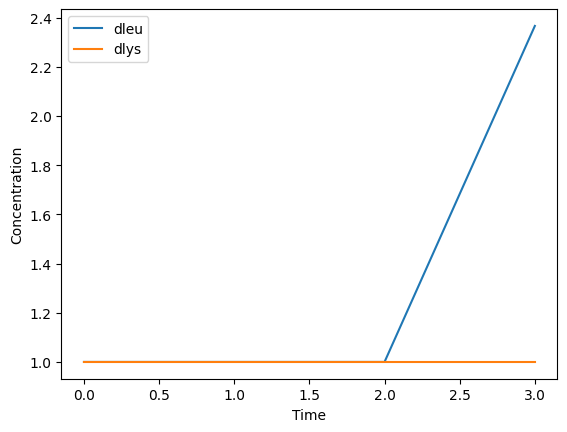

In [142]:
plot_biomasses(ep)